In [ ]:
!pip install asyncpraw torch torchvision torchaudio nest_asyncio matplotlib pandas numpy transformers


In [ ]:
import asyncpraw
import asyncio
import torch
import torch.nn.functional as F
import nest_asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
client_id = "HNUKCrL6c_00cpLjBCY5WQ"
client_secret = "twvnKPIbXVHZru7csyRMudPcLsIHYw"
user_agent = "Depsenanal/0.1 by u/KrishRON_TheDon"

async def get_reddit_user_activity(username):
    """Fetches last 10 Reddit comments + their subreddits."""
    reddit = asyncpraw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)

    try:
        redditor = await reddit.redditor(username)
        comments, subreddits = [], []

        async for comment in redditor.comments.new(limit=10):
            comments.append(comment.body)
            subreddits.append(comment.subreddit.display_name)

        return comments, subreddits

    except Exception as e:
        print(f"Error: {e}")
        return None, None
    finally:
        await reddit.close()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ckpt = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt).to(device)

emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def get_prediction(text):
    """Predicts emotion of a Reddit comment."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=50).to(device)

    with torch.no_grad():
        output = model(**inputs)

    probabilities = F.softmax(output.logits, dim=1)
    pred = torch.argmax(probabilities, dim=1).item()

    return emotion_labels[pred]

In [ ]:
def show_single_frame(comments, emotions, subreddits):
    """Creates a single frame with a BIGGER comment table on top and two side-by-side graphs below."""

    # Subreddit Frequency
    top_subreddits = Counter(subreddits).most_common(6)
    subreddit_labels, subreddit_counts = zip(*top_subreddits)

    # Emotion Count
    emotion_counts = {label: emotions.count(label) for label in emotion_labels}

    # Create Figure
    fig = plt.figure(figsize=(16, 14), facecolor="#121212")
    gs = fig.add_gridspec(3, 2, height_ratios=[2.5, 1, 1])

    fig.suptitle("💖 Emotions of Text 💖", fontsize=26, fontweight="bold", color="hotpink", fontname="Arial")

    # ==== 📜 Table: BIGGER Top-Half ====
    ax_table = fig.add_subplot(gs[0, :])
    ax_table.axis("off")

    table_data = [[comments[i][:150] + "...", subreddits[i], emotions[i]] for i in range(len(comments))]
    col_labels = ["📜 Reddit Comment", "🏠 Subreddit", "🎭 Predicted Emotion"]

    table = ax_table.table(
        cellText=table_data, colLabels=col_labels, cellLoc="center", loc="center",
        colColours=["#ff69b4", "#ff00ff", "#ff1493"], bbox=[0, 0, 1, 1]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(14)  # Bigger text
    table.scale(1.4, 1.4)  # Bigger table

    for cell in table.get_celld().values():
        cell.set_edgecolor("black")
        cell.set_facecolor("#222222")
        cell.get_text().set_color("white")

    # ==== 🎭 Emotion & Subreddit Pie Charts (Side-by-Side) ====
    ax1 = fig.add_subplot(gs[1:, 0])
    ax2 = fig.add_subplot(gs[1:, 1])

    # 🎭 Emotion Pie
    colors = ["#ff69b4", "#ff1493", "#ff4500", "#ff6347", "#ff00ff", "#ffb6c1"]
    wedges, texts, autotexts = ax1.pie(
        emotion_counts.values(), labels=emotion_labels, autopct="%1.1f%%",
        colors=colors, textprops={"fontsize": 14, "weight": "bold", "color": "white", "fontname": "Arial"},
        wedgeprops={"edgecolor": "black", "linewidth": 2, "antialiased": True},
        startangle=140
    )

    for text in texts + autotexts:
        text.set_fontsize(16)

    ax1.set_title("🌀 Emotion Analysis 🌀", fontsize=18, color="hotpink", fontweight="bold", fontname="Arial")

    # 🔥 Subreddit Pie
    colors_sub = ["#8a2be2", "#00ffff", "#ff4500", "#00ff7f", "#ff6347", "#ffff00"]
    wedges, texts, autotexts = ax2.pie(
        subreddit_counts, labels=subreddit_labels, autopct="%1.1f%%",
        colors=colors_sub, textprops={"fontsize": 14, "weight": "bold", "color": "white", "fontname": "Arial"},
        wedgeprops={"edgecolor": "black", "linewidth": 2, "antialiased": True},
        startangle=140
    )

    for text in texts + autotexts:
        text.set_fontsize(16)

    ax2.set_title("🔥 Subreddit Activity 🔥", fontsize=18, color="hotpink", fontweight="bold", fontname="Arial")

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

In [ ]:
async def main():
    username = "yuz_HUNKAI15"
    comments, subreddits = await get_reddit_user_activity(username)

    if not comments or not subreddits:
        print("No data found! Try again.")
        return

    # Get Emotions
    emotions = [get_prediction(comment) for comment in comments]

    # Display Table + Side-by-Side Pie Charts
    show_single_frame(comments, emotions, subreddits)

In [ ]:
nest_asyncio.apply()

def run_asyncio_main():
    loop = asyncio.get_event_loop()
    if loop.is_running():
        return asyncio.ensure_future(main())  # Workaround for Colab
    else:
        return asyncio.run(main())

run_asyncio_main()

<Task pending name='Task-1' coro=<main() running at <ipython-input-8-766ae61436fc>:1>>

In [ ]:
!pip install asyncpraw transformers torch matplotlib nest_asyncio pandas


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import asyncio
import asyncpraw
import nest_asyncio
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Apply nest_asyncio to handle async functions
nest_asyncio.apply()

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Load Emotion Analysis Model ==========
emotion_model_ckpt = "bhadresh-savani/distilbert-base-uncased-emotion"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_ckpt)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_ckpt).to(device)

# Emotion labels
emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]


In [ ]:
# Reddit API Credentials
client_id = "HNUKCrL6c_00cpLjBCY5WQ"
client_secret = "twvnKPIbXVHZru7csyRMudPcLsIHYw"
user_agent = "Depsenanal/0.1 by u/KrishRON_TheDon"

async def get_reddit_user_activity(username):
    """Fetches last 10 Reddit comments of a user."""
    reddit = asyncpraw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)
    try:
        redditor = await reddit.redditor(username)
        comments, subreddits = [], []
        async for comment in redditor.comments.new(limit=10):
            comments.append(comment.body)
            subreddits.append(comment.subreddit.display_name)
        return comments, subreddits
    except Exception as e:
        print(f"Error: {e}")
        return None, None
    finally:
        await reddit.close()


In [ ]:
def get_prediction(text):
    """Predicts emotion of a Reddit comment."""
    inputs = emotion_tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=50).to(device)
    with torch.no_grad():
        output = emotion_model(**inputs)
    return emotion_labels[torch.argmax(F.softmax(output.logits, dim=1)).item()]


In [ ]:
def generate_graphs(emotions, subreddits):
    """Generates pie charts for Emotion Analysis & Subreddit Activity."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Emotion Analysis Pie Chart
    emotion_counts = Counter(emotions)
    axes[0].pie(emotion_counts.values(), labels=emotion_counts.keys(), autopct="%1.1f%%", startangle=140)
    axes[0].set_title("Emotion Analysis")

    # Subreddit Activity Pie Chart
    subreddit_counts = Counter(subreddits)
    axes[1].pie(Counter(subreddits).values(), labels=Counter(subreddits).keys(), autopct="%1.1f%%", startangle=140)
    axes[1].set_title("Subreddit Activity")

    plt.tight_layout()
    plt.show()


Enter Reddit username: SriNivesh


,Comment,Subreddit,Emotion
0,"To answer the NRI question, the transmitted un...",personalfinanceindia,joy
1,Please review your statement and modify it. T...,personalfinanceindia,anger
2,There have been many accounts of made-in-India...,FIRE_Ind,anger
3,There is one thing about mutual funds that no ...,personalfinanceindia,anger
4,"THIS. \n\nIf we dig deep enough, there would d...",FIRE_Ind,joy
5,I wanted to comment on the 'at least one to tw...,backtoindia,joy
6,It is good to see many positive comments. I h...,personalfinanceindia,anger
7,20k with a risk capital - loan amount - of 10 ...,personalfinanceindia,joy
8,I had chosen to cross-post in this sub. I hav...,FIRE_Ind,joy
9,Some of you may know of my second career as a ...,IndiaInvestments,joy


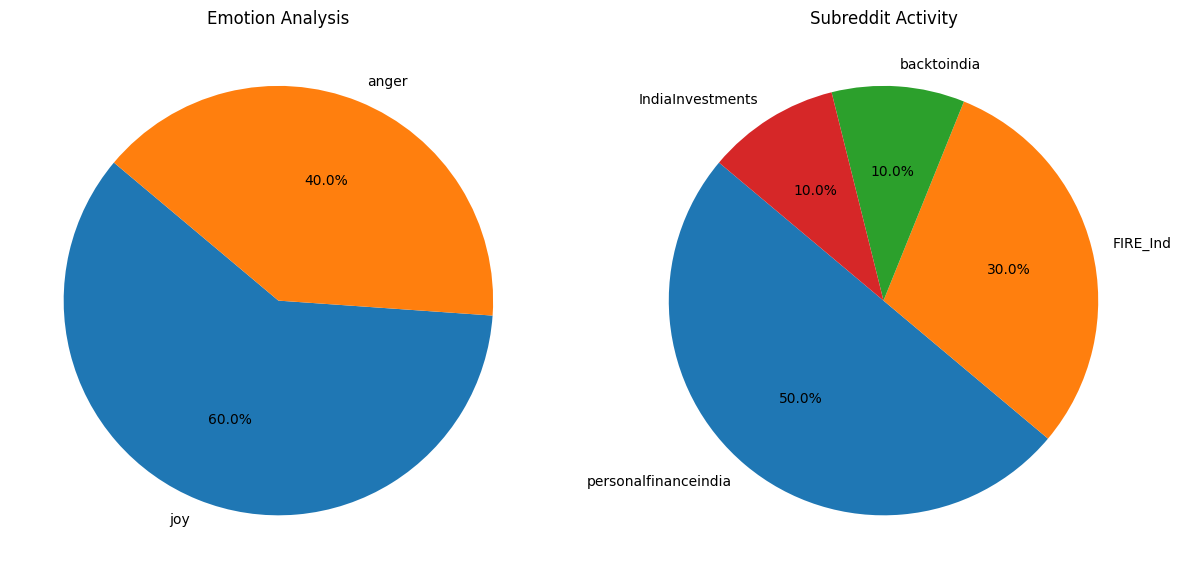

In [ ]:
# Ask for Reddit username
username = input("Enter Reddit username: ")

# Fetch Reddit data
comments, subreddits = asyncio.run(get_reddit_user_activity(username))

if comments:
    # Predict emotions
    emotions = [get_prediction(comment) for comment in comments]

    # Display DataFrame
    df = pd.DataFrame({"Comment": comments, "Subreddit": subreddits, "Emotion": emotions})
    display(df)

    # Generate Graphs
    generate_graphs(emotions, subreddits)
else:
    print("No data found! Check if the username is correct.")
